In [1]:
import os 
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import cdms
from rawio.IO import *
import pandas as pd
import qetpy as qp
from array import array

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 96 from PyObject


In [2]:
### This cell tries to setup a convertion factor, i.e once input is read from raw data in ADC units, convert it to Current (Amps)

'''
for CUTE

fs = 6.25e5 #sample points in per second
Rshunt = 5.0e-3 # shunt resistance on the TES circuit diagram
Rfb = 5000.0 # feedback resistance on the TES circuit diagram
ADCperVolt = 65536.0/8.0 # the number of ADC bins per V for the readout (16 bit digitizer going from -4V to 4V, hence 2^16 divided by 8)
LoopRatio = 2.4 # SQUID turn ratio at CUTE
scale = Rfb*ADCperVolt*LoopRatio

'''


### For UMN 
fs = 1.25e6 #sample points in per second
Rshunt = 8.0e-3 # shunt resistance on the TES circuit diagram
Rfb = 1000 # feedback resistance on the TES circuit diagram
ADCperVolt = 16384./2.5 # the number of ADC bins per V for the readout (14 bit digitizer going from -1.25V to +1.25V, hence 2^14 divided by 2.5)
LoopGain = 10000 # Phonon feeback gain (=10 (input/fb turn ratio) * 1000 Ohm fb resistor)
DG = 20 # driver gain
scale = ADCperVolt*LoopGain

In [3]:
# raw-events path: /data/chocula/fritts/data/k100proc/midasraw/byseries/
#frittsdir='/data/chocula/fritts/data/k100proc/midasraw/byseries/07220420_0842/07220420_0842_F0011.mid.gz'
frittsdir='/data/chocula/fritts/data/k100proc/midasraw/byseries/'
voltages = ['0V','4V','20V','65V','84V']
series = {
    '0V' : '07220822_1828',
    '4V' : '07220826_1219',
    '20V' : '07220826_1536',
    '65V' : '07220826_2007',
    '84V' : '07220827_1153'
}
#events= cdms.rawio.IO.getRawEvents(frittsdir,series,maxNumEvents=1000)

events={}
for volt in voltages:
    events[volt] = cdms.rawio.IO.getRawEvents(frittsdir,series[volt],maxNumEvents=1000)

The file is: /data/chocula/fritts/data/k100proc/midasraw/byseries//07220822_1828/07220822_1828_F0001.mid.gz

Opened raw midas file: /data/chocula/fritts/data/k100proc/midasraw/byseries//07220822_1828/07220822_1828_F0001.mid.gz
The file is: /data/chocula/fritts/data/k100proc/midasraw/byseries//07220826_1219/07220826_1219_F0001.mid.gz

Opened raw midas file: /data/chocula/fritts/data/k100proc/midasraw/byseries//07220826_1219/07220826_1219_F0001.mid.gz
The file is: /data/chocula/fritts/data/k100proc/midasraw/byseries//07220826_1536/07220826_1536_F0001.mid.gz

Opened raw midas file: /data/chocula/fritts/data/k100proc/midasraw/byseries//07220826_1536/07220826_1536_F0001.mid.gz
The file is: /data/chocula/fritts/data/k100proc/midasraw/byseries//07220826_2007/07220826_2007_F0001.mid.gz

Opened raw midas file: /data/chocula/fritts/data/k100proc/midasraw/byseries//07220826_2007/07220826_2007_F0001.mid.gz
The file is: /data/chocula/fritts/data/k100proc/midasraw/byseries//07220827_1153/07220827_11

In [4]:
events['0V'].head(2)

Z1  \
                                                                  QI   
72208221828 10000  [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            10001  [65532, 65532, 65532, 65532, 65532, 65532, 655...   

                                                                      \
                                                                  QO   
72208221828 10000  [41553, 41604, 41507, 41578, 41506, 41575, 415...   
            10001  [41530, 41563, 41535, 41553, 41527, 41527, 415...   

                                                                      \
                                                                  PA   
72208221828 10000  [2809, 2811, 2809, 2811, 2807, 2809, 2810, 281...   
            10001  [2796, 2794, 2796, 2793, 2796, 2793, 2796, 279...   

                                                                      \
                                                                  PB   
72208221828 10000  [2476, 2477, 2475, 2479, 2476, 2476, 2479, 247...   
            10001  [2464, 2461, 2463, 2460, 2461, 2461, 2463, 246...   

                                                                      \
                                                                  PC   
72208221828 10000  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
            10001  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                                      \
                                                                  PD   
72208221828 10000  [2711, 2713, 2711, 2707, 2708, 2706, 2710, 271...   
            10001  [2695, 2694, 2694, 2693, 2693, 2694, 2691, 269...   

                                                                  Z3  \
                                                                  QI   
72208221828 10000  [33718, 33722, 33722, 33719, 33713, 33717, 337...   
            10001  [33707, 33705, 33705, 33707, 33705, 33705, 337...   

                                                                      \
                                                                  QO   
72208221828 10000  [33564, 33557, 33563, 33563, 33566, 33555, 335...   
            10001  [33562, 33566, 33560, 33564, 33567, 33562, 335...   

                                                                      \
                                                                  PA   
72208221828 10000  [3122, 3122, 3125, 3126, 3124, 3126, 3123, 312...   
            10001  [3104, 3103, 3104, 3105, 3104, 3107, 3108, 310...   

                                                                      \
                                                                  PB   
72208221828 10000  [2597, 2599, 2603, 2602, 2602, 2603, 2601, 260...   
            10001  [2589, 2584, 2586, 2588, 2584, 2586, 2588, 258...   

                                                                      \
                                                                  PC   
72208221828 10000  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
            10001  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                                      
                                                                  PD  
72208221828 10000  [2685, 2682, 2683, 2684, 2682, 2683, 2684, 268...  
            10001  [2665, 2663, 2666, 2669, 2668, 2663, 2667, 266...

In [5]:
channels = ['PA','PB','PC','PD','PE','PF']
noise_psd_cut = {}
noise_psd_nocut = {}
cut = {}


traces = {}
tracesAmps = {}
for volt in voltages: 
    traces[volt] = {}
    tracesAmps[volt] = {}
    noise_psd_cut[volt] = {}
    noise_psd_nocut[volt] = {}
    cut[volt] = {}
    

In [6]:

for volt in voltages:
    traces[volt]['PB'] = events[volt]['Z1']['PA']
    traces[volt]['PA'] = events[volt]['Z1']['PB']
    traces[volt]['PD'] = events[volt]['Z1']['PD']
    traces[volt]['PC'] = events[volt]['Z3']['PA']
    traces[volt]['PF'] = events[volt]['Z3']['PB']
    traces[volt]['PE'] = events[volt]['Z3']['PD']

        
print('Done')

for volt in voltages:
    print('****** %s ******'%(volt))
    conv2Amp = 1./(scale*DG)
    for chan in traces[volt].keys():
        temp = []
        for i in traces[volt][chan][int(series[volt]),:].values[:]:
            temp.append(i*conv2Amp)
        tracesAmps[volt][chan] = np.asarray(temp)
        print('  Traces in %s = %d'%(chan,len(tracesAmps[volt][chan])))
        


# for chan in traces.keys():
#     temp = []
#     conv2Amp = 1./(scale*DG)
#     for i in traces[chan][int(series),:].values[:]:
#         temp.append(i*conv2Amp)
#     tracesAmps[chan] = np.asarray(temp)
#     print(chan,' : ',tracesAmps[chan].shape)
#    print('Traces in %s = %d'%(key,len(tracesAmps[key])))

Done
****** 0V ******
  Traces in PB = 1000
  Traces in PA = 1000
  Traces in PD = 1000
  Traces in PC = 1000
  Traces in PF = 1000
  Traces in PE = 1000
****** 4V ******
  Traces in PB = 1000
  Traces in PA = 1000
  Traces in PD = 1000
  Traces in PC = 1000
  Traces in PF = 1000
  Traces in PE = 1000
****** 20V ******
  Traces in PB = 1000
  Traces in PA = 1000
  Traces in PD = 1000
  Traces in PC = 1000
  Traces in PF = 1000
  Traces in PE = 1000
****** 65V ******
  Traces in PB = 1000
  Traces in PA = 1000
  Traces in PD = 1000
  Traces in PC = 1000
  Traces in PF = 1000
  Traces in PE = 1000
****** 84V ******
  Traces in PB = 1000
  Traces in PA = 1000
  Traces in PD = 1000
  Traces in PC = 1000
  Traces in PF = 1000
  Traces in PE = 1000


# IteCut

In [7]:
### Initialization
cut_pars = {'sigma':2.5}
cminmax = {}
cbaseline = {}
cslope = {}
IC_cuts = {
    'def' : 'No cut',
    'minmax' : 'minmax',
    'baseline' : '+ baseline outlier',
    'slope' : '+ baseline slope'
}
traces_cuts = {}

for volt in voltages: 
    cminmax[volt] = {}
    cbaseline[volt] = {}
    cslope[volt] = {}
    traces_cuts[volt] = {}
    for chan in channels:
        traces_cuts[volt][chan] = {}
    


## Calculation
for volt in voltages:
    print('****** %s ******'%(volt))
    for i,chan in enumerate(channels):
        traces_cuts[volt][chan]['def'] = tracesAmps[volt][chan]
        IC_temp = qp.IterCut(tracesAmps[volt][chan], fs)
        cminmax[volt][chan] = IC_temp.minmaxcut(cut_pars)
        cbaseline[volt][chan] = IC_temp.baselinecut(cut_pars)
        cslope[volt][chan] = IC_temp.slopecut(cut_pars)
        cmask = cminmax[volt][chan]
        traces_cuts[volt][chan]['minmax'] = tracesAmps[volt][chan][cmask]
        cmask = cmask & cbaseline[volt][chan]
        traces_cuts[volt][chan]['baseline'] = tracesAmps[volt][chan][cmask]
        cmask = cmask & cslope[volt][chan]
        traces_cuts[volt][chan]['slope'] = tracesAmps[volt][chan][cmask]
        print('  %s saved..'%(chan))
        
print('Done!')

****** 0V ******
  PA saved..
  PB saved..
  PC saved..
  PD saved..
  PE saved..
  PF saved..
****** 4V ******
  PA saved..
  PB saved..
  PC saved..
  PD saved..
  PE saved..
  PF saved..
****** 20V ******
  PA saved..
  PB saved..
  PC saved..
  PD saved..
  PE saved..
  PF saved..
****** 65V ******
  PA saved..
  PB saved..
  PC saved..
  PD saved..
  PE saved..
  PF saved..
****** 84V ******
  PA saved..
  PB saved..
  PC saved..
  PD saved..
  PE saved..
  PF saved..
Done!


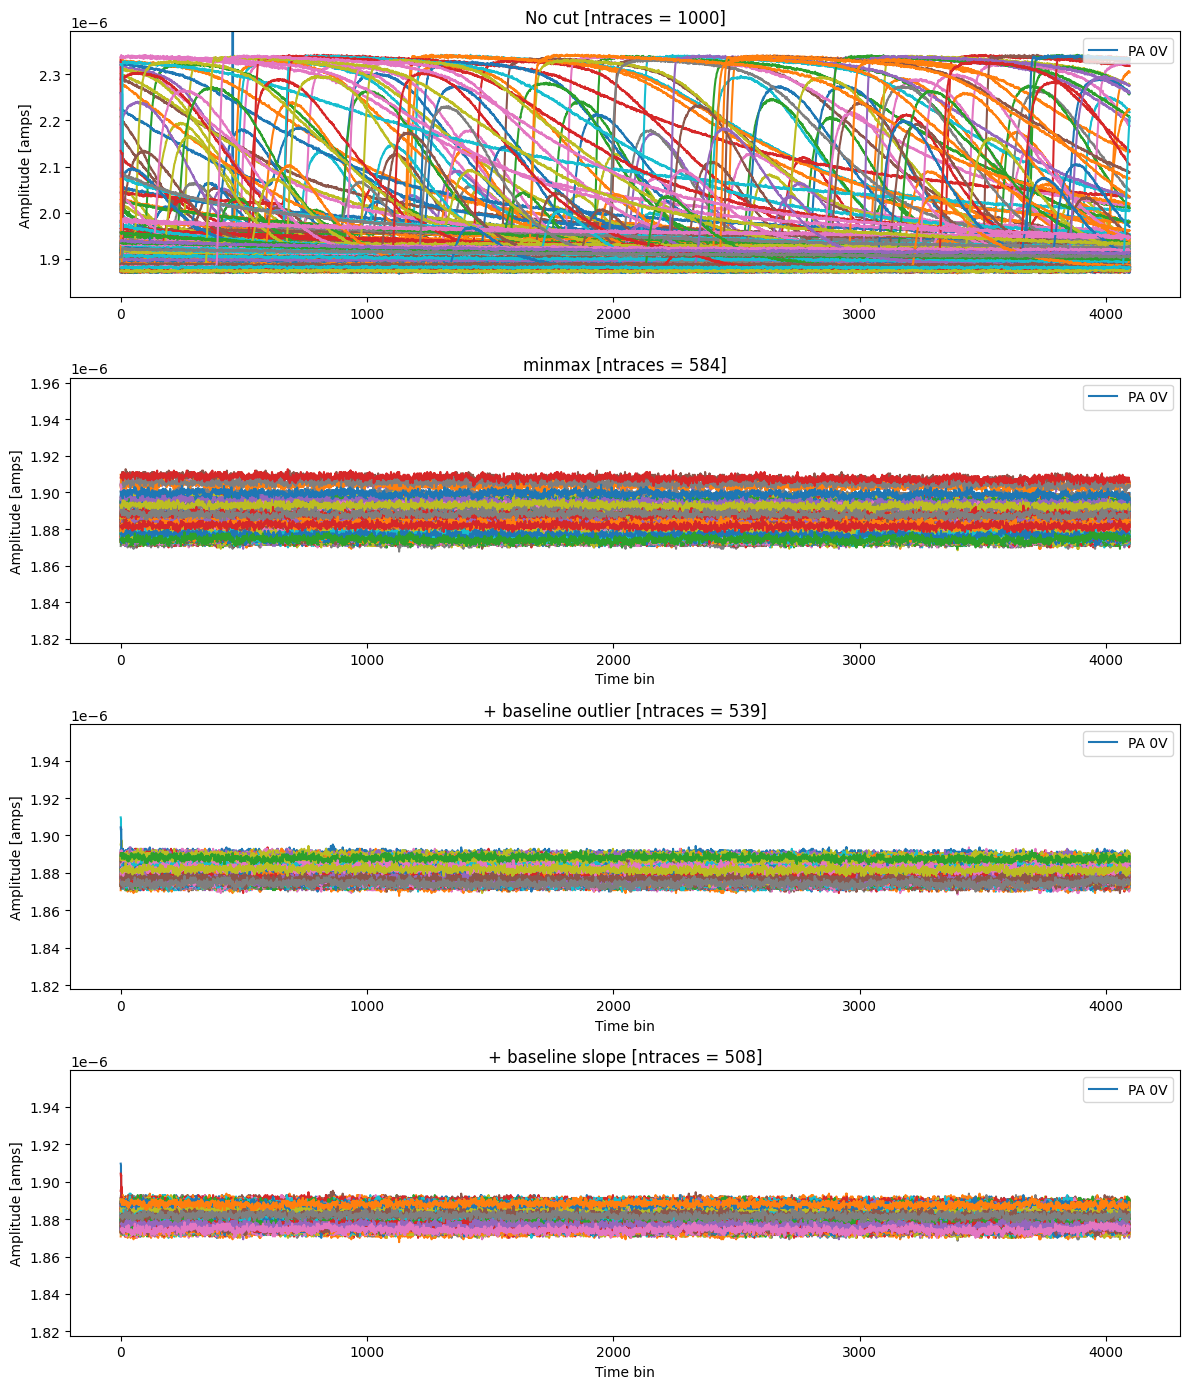

In [8]:
volt = '0V'
chan = 'PA'
fig, axs = plt.subplots(4, 1, figsize=(12,14))
#pp=[(0,0), (0,1), (1,0), (1,1),(2,0),(2,1)]
pp=[0,1,2,3,4]

for i,cut in enumerate(IC_cuts.keys()):
    xmin = 1.
    xmax = -1.
    for j,trace in enumerate(traces_cuts[volt][chan][cut]):
        ntraces = -1
        if(cut == 'def'):
            ntraces = len(traces_cuts[volt][chan][cut])
        elif(cut=='minmax'):
            ntraces = np.sum(cminmax[volt][chan])
        elif(cut=='baseline'):
            ntraces = np.sum(cbaseline[volt][chan])
        elif(cut=='slope'):
            ntraces = np.sum(cslope[volt][chan])
        if(j == 0):
            axs[pp[i]].plot(trace,label=chan+' '+volt)
            axs[pp[i]].legend(loc='upper right')
        else:
            axs[pp[i]].plot(trace)
        if(np.min(trace) < xmin):
            xmin = np.min(trace)
        if(np.max(trace) > xmax):
            if(np.max(trace) < 3.5e-6):
                xmax = np.max(trace)
            
        #axs.grid()
    axs[pp[i]].set_ylim([xmin-0.05e-6,xmax+0.05e-6])
    axs[pp[i]].set_title(IC_cuts[cut]+' [ntraces = %d]'%(ntraces))
    axs[pp[i]].set_xlabel('Time bin')
    axs[pp[i]].set_ylabel('Amplitude [amps]')
fig.tight_layout()

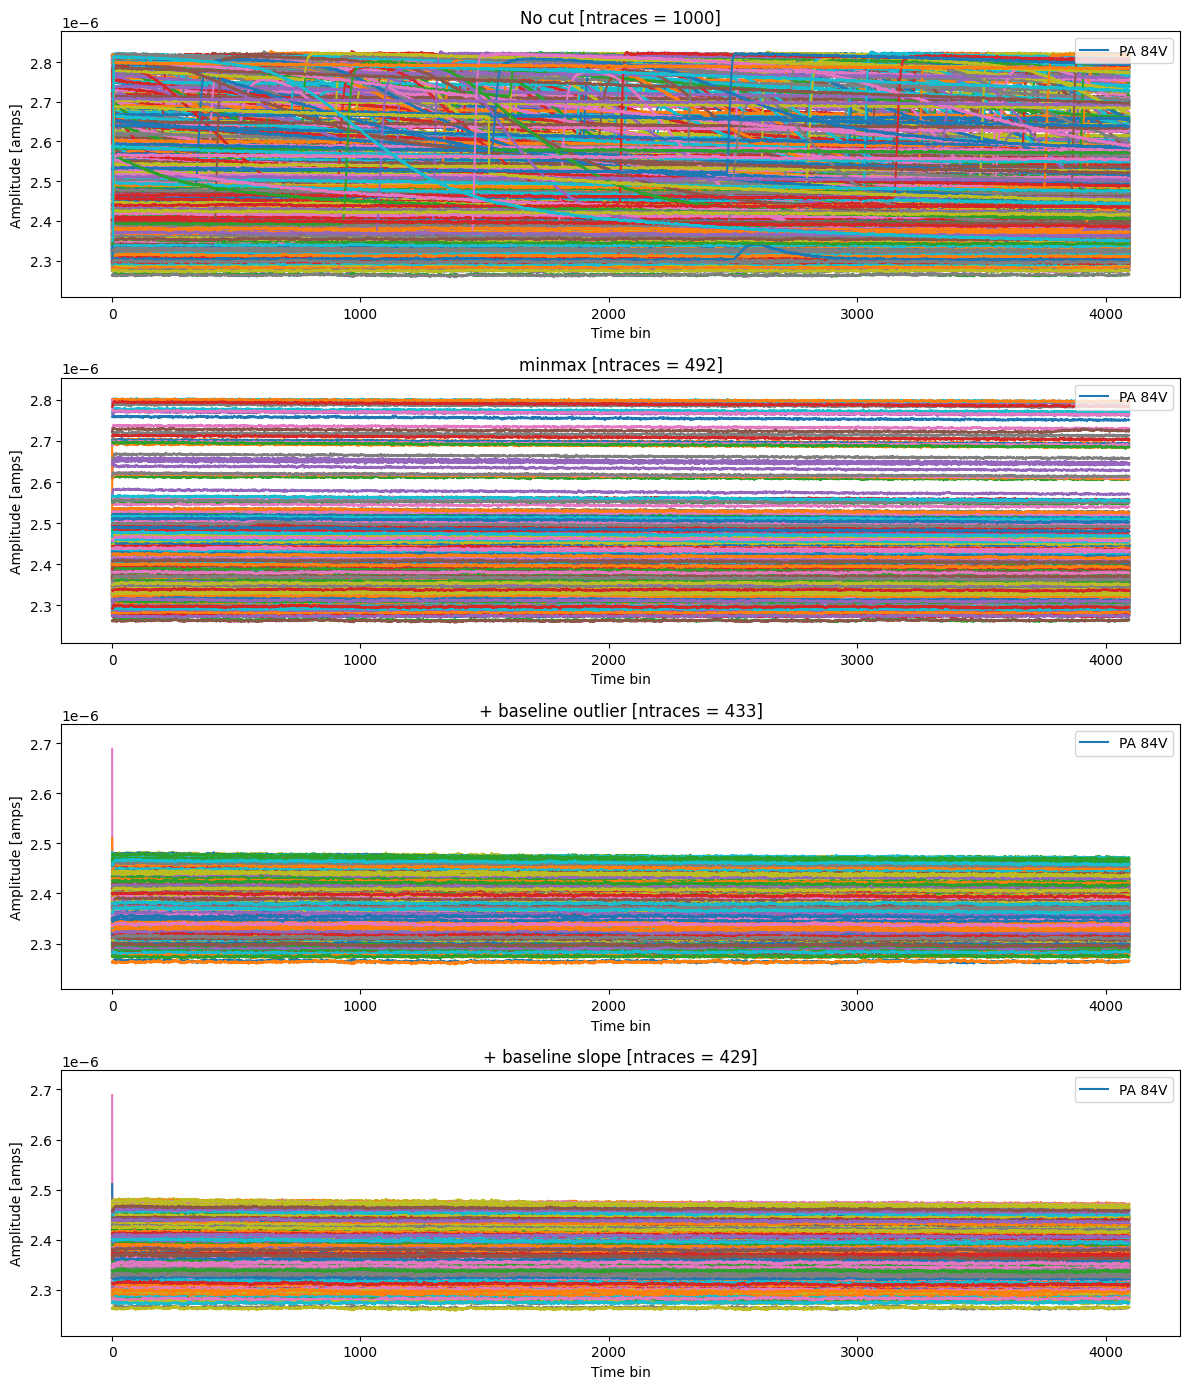

In [9]:
volt = '84V'
chan = 'PA'
fig, axs = plt.subplots(4, 1, figsize=(12,14))
#pp=[(0,0), (0,1), (1,0), (1,1),(2,0),(2,1)]
pp=[0,1,2,3,4]

for i,cut in enumerate(IC_cuts.keys()):
    xmin = 1.
    xmax = -1.
    for j,trace in enumerate(traces_cuts[volt][chan][cut]):
        ntraces = -1
        if(cut == 'def'):
            ntraces = len(traces_cuts[volt][chan][cut])
        elif(cut=='minmax'):
            ntraces = np.sum(cminmax[volt][chan])
        elif(cut=='baseline'):
            ntraces = np.sum(cbaseline[volt][chan])
        elif(cut=='slope'):
            ntraces = np.sum(cslope[volt][chan])
        if(j == 0):
            axs[pp[i]].plot(trace,label=chan+' '+volt)
            axs[pp[i]].legend(loc='upper right')
        else:
            axs[pp[i]].plot(trace)
        if(np.min(trace) < xmin):
            xmin = np.min(trace)
        if(np.max(trace) > xmax):
            if(np.max(trace) < 3.5e-6):
                xmax = np.max(trace)
            
        #axs.grid()
    axs[pp[i]].set_ylim([xmin-0.05e-6,xmax+0.05e-6])
    axs[pp[i]].set_title(IC_cuts[cut]+' [ntraces = %d]'%(ntraces))
    axs[pp[i]].set_xlabel('Time bin')
    axs[pp[i]].set_ylabel('Amplitude [amps]')
fig.tight_layout()

In [99]:
np.min([1.,2.,3.])

1.0

In [58]:
nmax = 1000

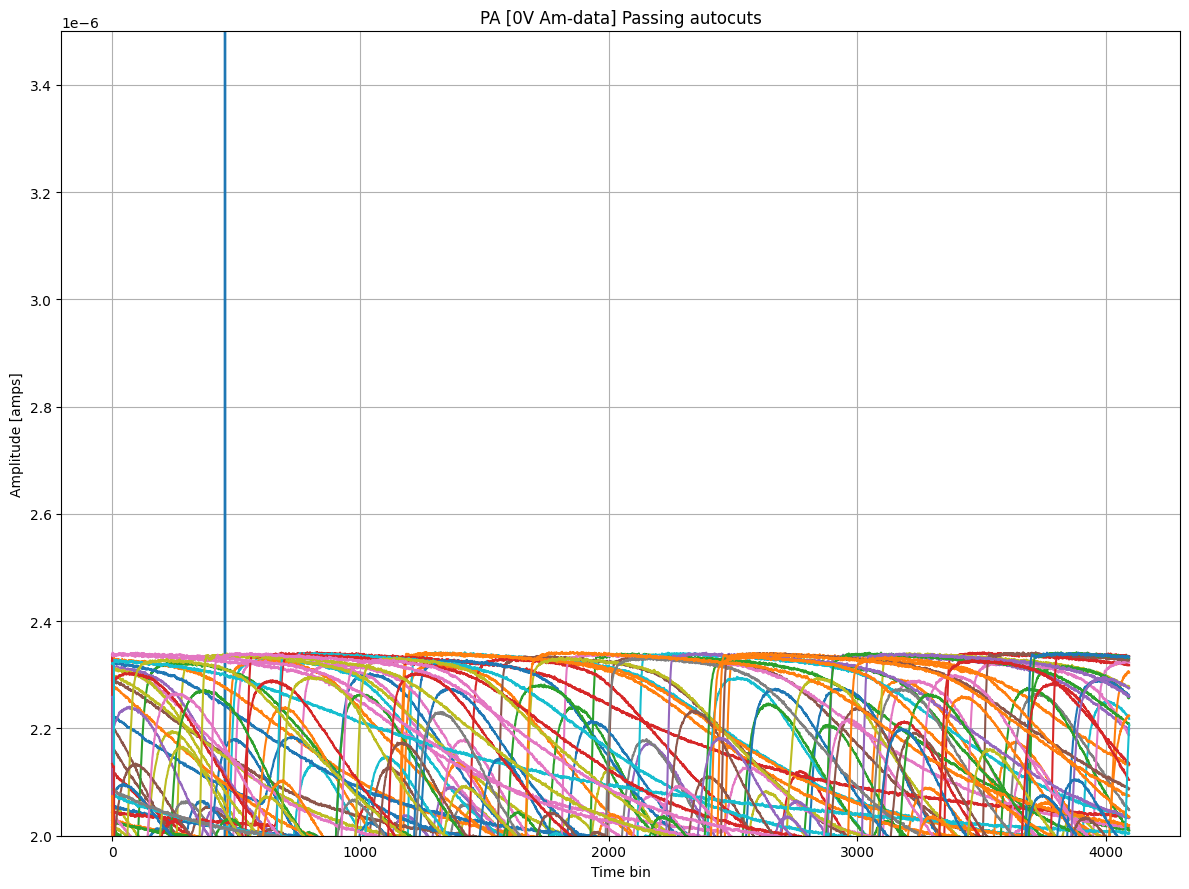

In [67]:
fig, axs = plt.subplots(1, 1, figsize=(12,9))
pp=[(0,0), (0,1)]
eid = 0
#eid = 15000
chan = 'PA'
for trace in tracesAmps[chan][:nmax]:
    axs.plot(trace)

#axs.legend(loc='upper right')
#axs[pp[i]].title('PC [0V Am-data]')
axs.grid()
axs.set_ylim([2e-6,3.5e-6])
axs.set_title(chan+' [0V Am-data] Passing autocuts')
axs.set_xlabel('Time bin')
axs.set_ylabel('Amplitude [amps]')

fig.tight_layout()

In [68]:
IC = qp.IterCut(tracesAmps[chan][:nmax], fs)
cut_pars = {'sigma':2.5}
cminmax = IC.minmaxcut(cut_pars)
cbaseline = IC.baselinecut(cut_pars)
cmask = (cminmax & cbaseline)

In [69]:
np.sum(cminmax)

584

In [70]:
np.sum(cmask)

539

Passing fraction: 0.584


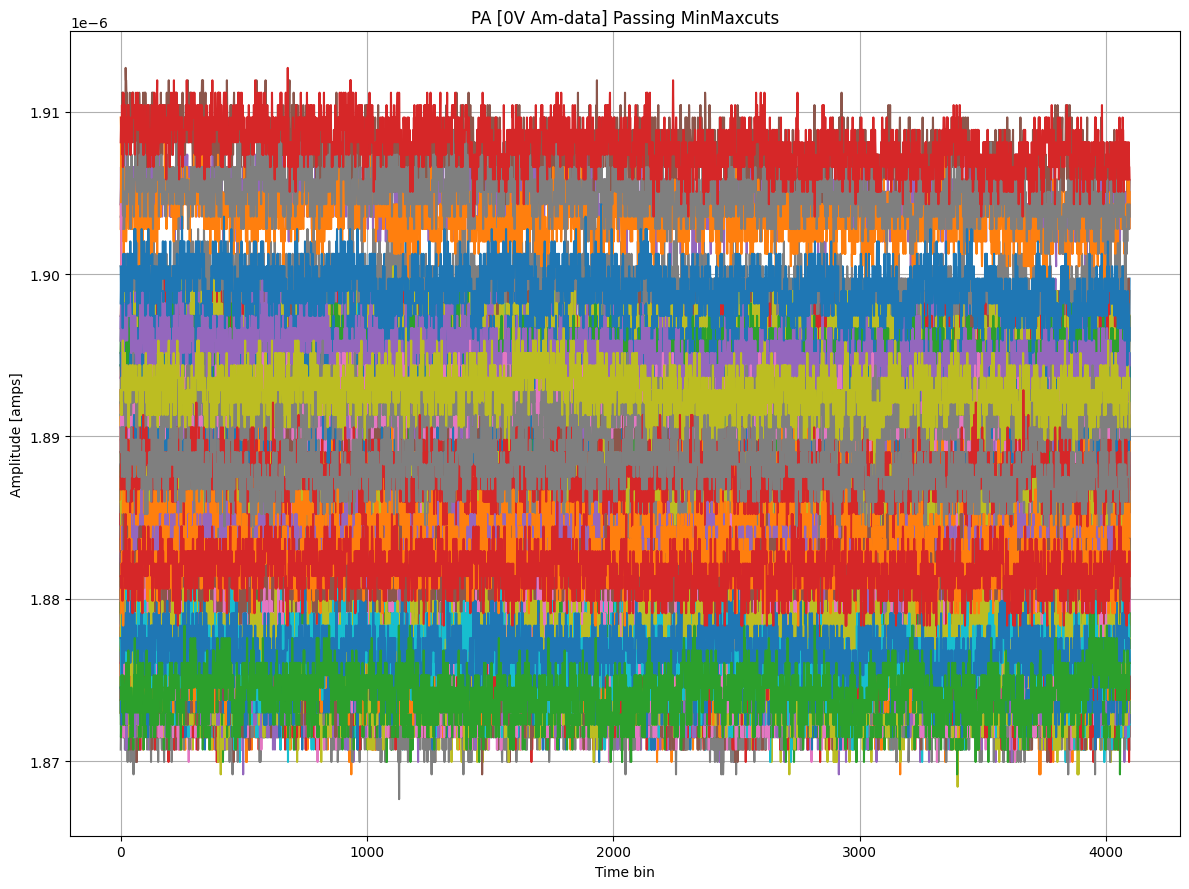

In [72]:
fig, axs = plt.subplots(1, 1, figsize=(12,9))
pp=[(0,0), (0,1)]
eid = 0
#eid = 15000
#chan = 'PC'
for trace in tracesAmps[chan][:nmax][cminmax]:
    axs.plot(trace)
    
print('Passing fraction: %0.3f'%(np.sum(cminmax)/len(tracesAmps[chan][:nmax])))
#axs[0].legend(loc='upper right')
#axs[pp[i]].title('PC [0V Am-data]')
axs.grid()
#axs.set_ylim([2e-6,3e-6])
axs.set_title(chan+' [0V Am-data] Passing MinMaxcuts')
axs.set_xlabel('Time bin')
axs.set_ylabel('Amplitude [amps]')

fig.tight_layout()

Passing fraction: 0.539


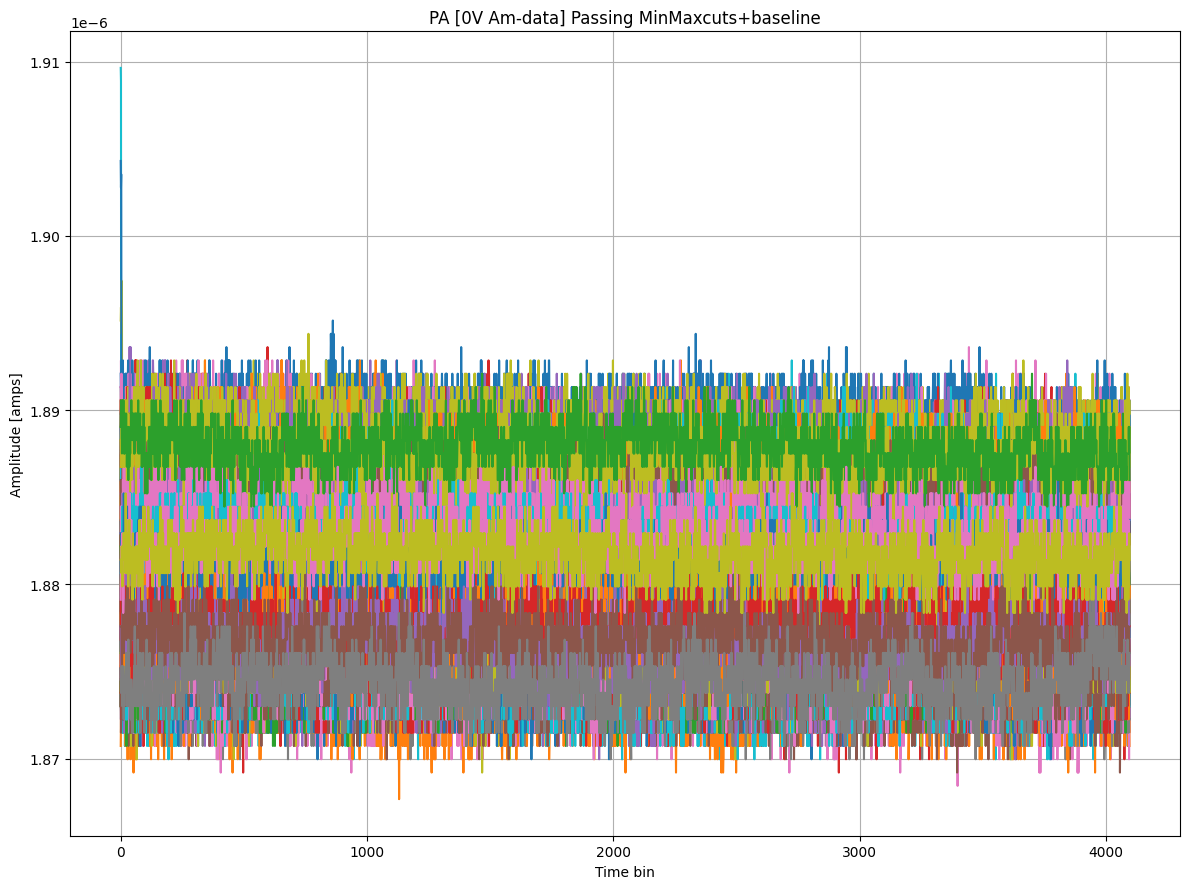

In [74]:
fig, axs = plt.subplots(1, 1, figsize=(12,9))
pp=[(0,0), (0,1)]
eid = 0
#eid = 15000

for trace in tracesAmps[chan][:nmax][cmask]:
    axs.plot(trace)
    
print('Passing fraction: %0.3f'%(np.sum(cmask)/len(tracesAmps[chan][:nmax])))
#axs[0].legend(loc='upper right')
#axs[pp[i]].title('PC [0V Am-data]')
axs.grid()
#axs.set_ylim([2e-6,3e-6])
axs.set_title(chan+' [0V Am-data] Passing MinMaxcuts+baseline')
axs.set_xlabel('Time bin')
axs.set_ylabel('Amplitude [amps]')

fig.tight_layout()

In [76]:
cslope = IC.slopecut(cut_pars)
cmask = (cmask & cslope)
np.sum(cmask)

508

Passing fraction: 0.508


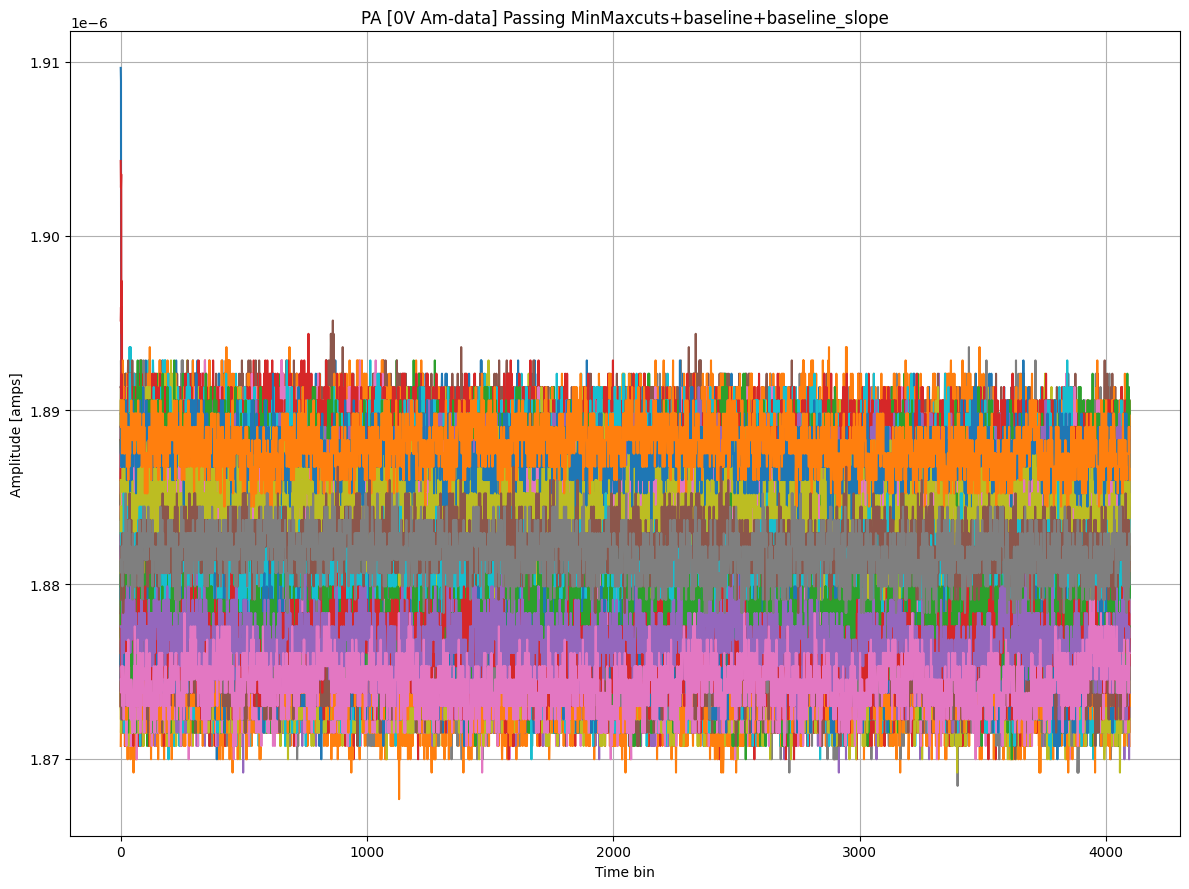

In [77]:
fig, axs = plt.subplots(1, 1, figsize=(12,9))
pp=[(0,0), (0,1)]
eid = 0
#eid = 15000
#chan = 'PC'
for trace in tracesAmps[chan][:nmax][cmask]:
    axs.plot(trace)
    
print('Passing fraction: %0.3f'%(np.sum(cmask)/len(tracesAmps[chan][:nmax])))
#axs[0].legend(loc='upper right')
#axs[pp[i]].title('PC [0V Am-data]')
axs.grid()
#axs.set_ylim([2e-6,3e-6])
axs.set_title(chan+' [0V Am-data] Passing MinMaxcuts+baseline+baseline_slope')
axs.set_xlabel('Time bin')
axs.set_ylabel('Amplitude [amps]')

fig.tight_layout()

In [8]:
qp.__version__

'1.6.3'

In [11]:
traces['PC'][:10]

72208221828  10000    [3122, 3122, 3125, 3126, 3124, 3126, 3123, 312...
             10001    [3104, 3103, 3104, 3105, 3104, 3107, 3108, 310...
             10002    [3146, 3162, 3167, 3170, 3166, 3162, 3164, 316...
             10003    [3116, 3115, 3115, 3116, 3116, 3113, 3113, 311...
             10004    [3105, 3106, 3116, 3116, 3116, 3119, 3118, 311...
             10005    [3456, 3451, 3448, 3450, 3448, 3444, 3445, 344...
             10006    [3114, 3113, 3116, 3112, 3111, 3115, 3117, 311...
             10007    [3106, 3107, 3111, 3110, 3110, 3108, 3112, 310...
             10008    [3135, 3135, 3137, 3138, 3135, 3135, 3136, 313...
             10009    [3107, 3126, 3128, 3129, 3126, 3127, 3128, 313...
Name: PA, dtype: object

In [32]:
#IC = qp.IterCut(traces['PC'], fs, lgc_plot=True, nplot=10)
IC = qp.IterCut(traces['PC'][:10], fs)
#cpileup = IC.pileupcut(cut=2)
#cpileup1 = IC.cmask
#cut_pars = {'slopecut' : {'sigma':2.5}}
cut_pars = {'sigma':2.5}
cslope = IC.slopecut(cut_pars)
#cbaseline = IC.baselinecut('sigma')
#cchi2 = IC.chi2cut(cut=3)
#cut_ic = IC.cmask

InvalidIndexError: [0 1 2 3 4 5 6 7 8 9]

In [5]:
qp.__version__

'1.6.3'

In [22]:
?qp.IterCut.slopecut

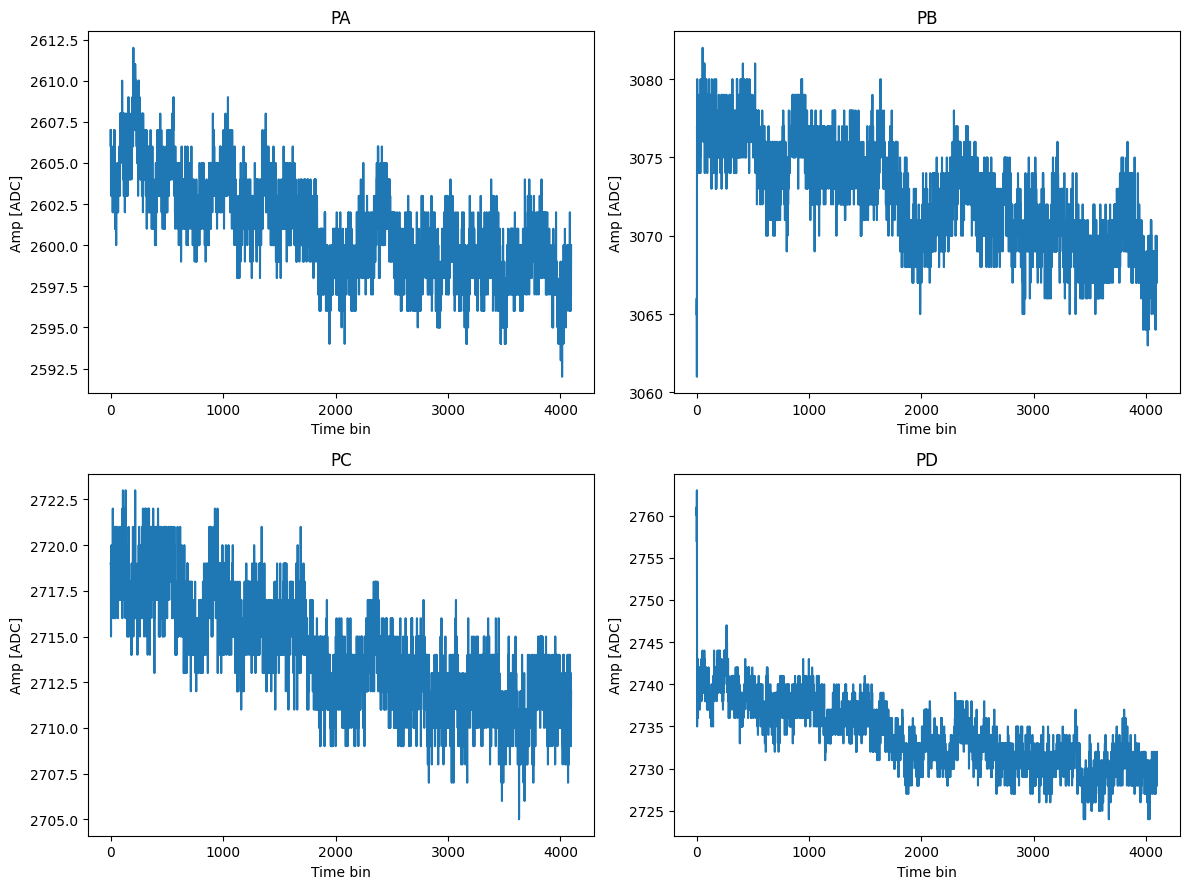

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(12,9))
pp=[(0,0), (0,1), (1,0), (1,1)]
eid = 0
#eid = 15000
for i,chan in enumerate(channels):
    if(i > 3):
        break
    trace_median = 0 #np.median(traces[chan].iloc[eid][10:500])
    axs[pp[i]].plot(traces[chan].iloc[eid] - trace_median)
    axs[pp[i]].set_title(chan)
    axs[pp[i]].set_xlabel('Time bin')
    axs[pp[i]].set_ylabel('Amp [ADC]')
fig.tight_layout()

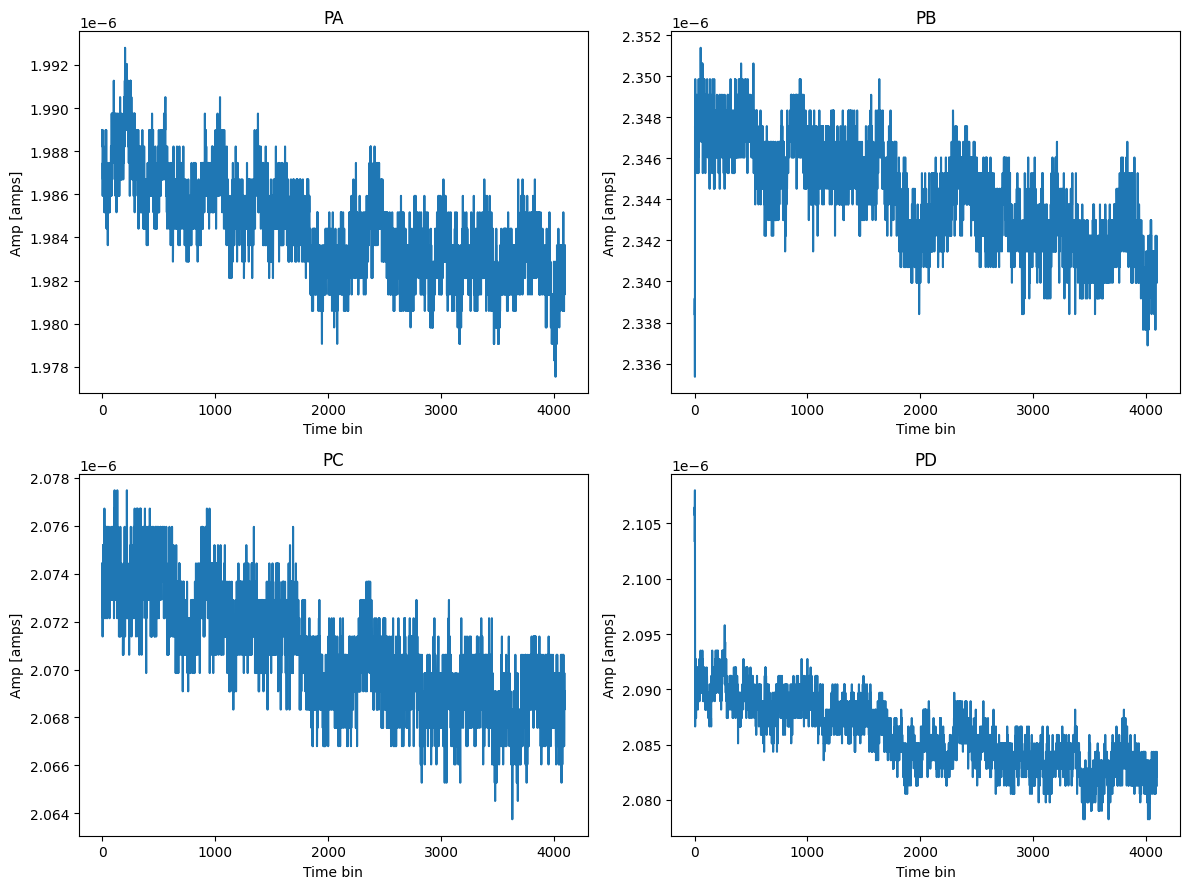

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(12,9))
pp=[(0,0), (0,1), (1,0), (1,1)]
eid = 0
#eid = 15000
for i,chan in enumerate(channels):
    if(i > 3):
        break
    trace_median = 0 #np.median(traces[chan].iloc[eid][10:500])
    traceAmp = traces[chan].iloc[eid]/(scale*DG)
    axs[pp[i]].plot(traceAmp - trace_median)
    axs[pp[i]].set_title(chan)
    axs[pp[i]].set_xlabel('Time bin')
    axs[pp[i]].set_ylabel('Amp [amps]')
fig.tight_layout()

In [8]:
tracesAmps.keys()

dict_keys(['PA', 'PB', 'PC', 'PD', 'PE', 'PF'])

In [11]:
noise_psd_cut = {}
noise_psd_nocut = {}
cut = {}
for i,chan in enumerate(channels):
    cut[chan] = qp.autocuts(tracesAmps[chan], fs)    
    noise_psd_nocut[chan] = qp.calc_psd(tracesAmps[chan], fs=fs, folded_over=True)
    noise_psd_cut[chan] = qp.calc_psd(tracesAmps[chan][cut[chan]], fs=fs, folded_over=True)
    print('%s : Cut efficieny is %0.3f'%(chan, np.sum(cut[chan])/len(tracesAmps[chan])))

PA : Cut efficieny is 0.062
PB : Cut efficieny is 0.112
PC : Cut efficieny is 0.110
PD : Cut efficieny is 0.072
PE : Cut efficieny is 0.091
PF : Cut efficieny is 0.108


<>:14: DeprecationWarning: invalid escape sequence \s
<>:14: DeprecationWarning: invalid escape sequence \s
/tmp/ipykernel_1404271/2907109942.py:14: DeprecationWarning: invalid escape sequence \s
  axs[pp[i]].set_ylabel('Noise PSD [A/$\sqrt{Hz}$]')


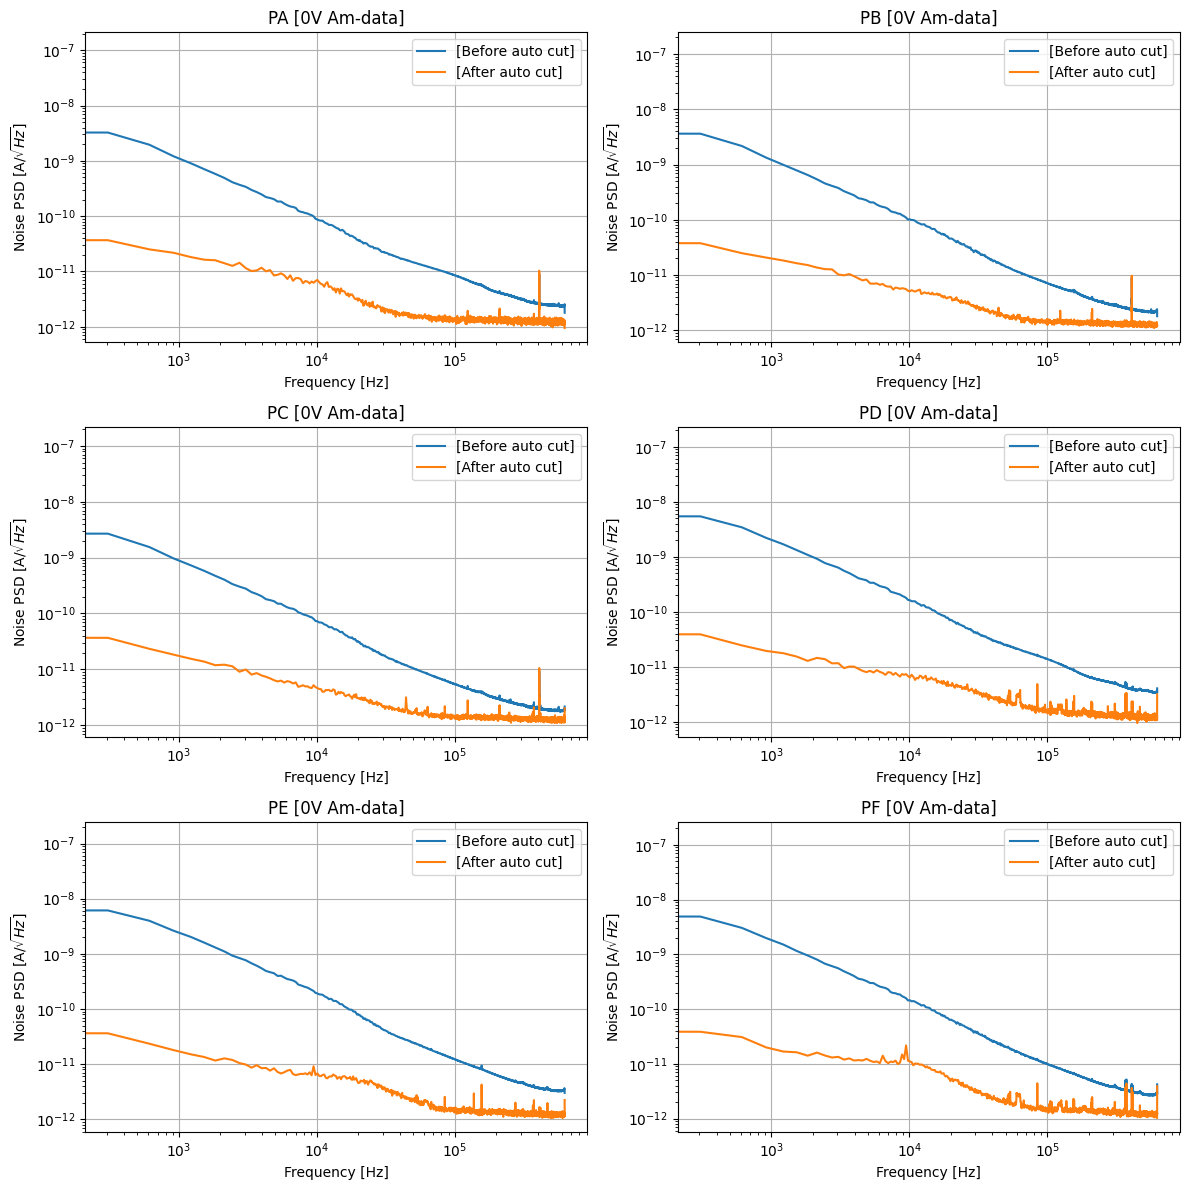

In [10]:
fig, axs = plt.subplots(3, 2, figsize=(12,12))
pp=[(0,0), (0,1), (1,0), (1,1),(2,0),(2,1)]
for i,chan in enumerate(channels):
#     if(i > 3):
#         break
    axs[pp[i]].loglog(noise_psd_nocut[chan][0],np.sqrt(noise_psd_nocut[chan][1]),label='[Before auto cut]')
    axs[pp[i]].loglog(noise_psd_cut[chan][0],np.sqrt(noise_psd_cut[chan][1]),label='[After auto cut]')
    axs[pp[i]].legend(loc='upper right')
    #axs[pp[i]].title('PC [0V Am-data]')
    axs[pp[i]].grid()
    #axs[pp[i]].set_ylim([1e-12,1e-10])
    axs[pp[i]].set_title(chan+' [0V Am-data]')
    axs[pp[i]].set_xlabel('Frequency [Hz]')
    axs[pp[i]].set_ylabel('Noise PSD [A/$\sqrt{Hz}$]')
fig.tight_layout()

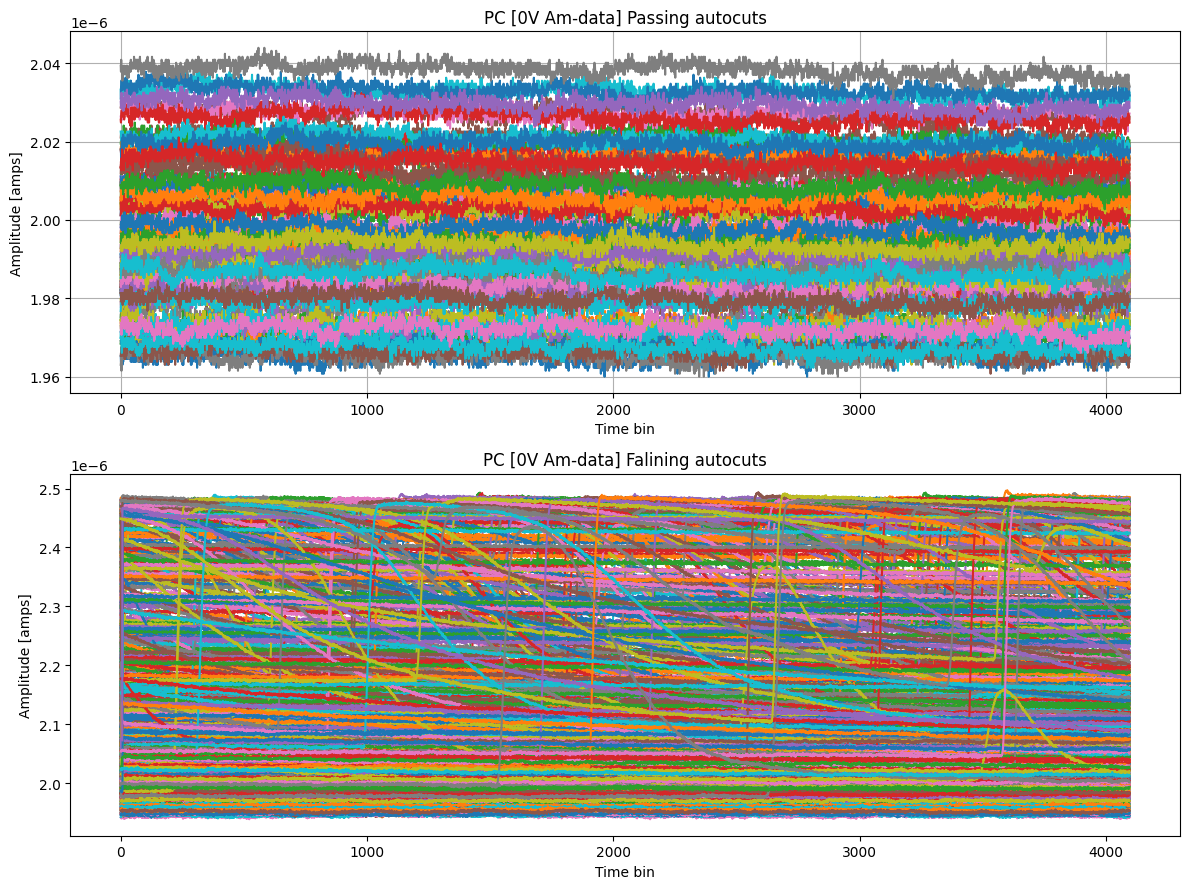

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(12,9))
pp=[(0,0), (0,1)]
eid = 0
#eid = 15000
chan = 'PC'
for trace in tracesAmps[chan][cut[chan]]:
    axs[0].plot(trace)

#axs[0].legend(loc='upper right')
#axs[pp[i]].title('PC [0V Am-data]')
axs[0].grid()
#axs[pp[i]].set_ylim([1e-12,1e-10])
axs[0].set_title(chan+' [0V Am-data] Passing autocuts')
axs[0].set_xlabel('Time bin')
axs[0].set_ylabel('Amplitude [amps]')

for trace in tracesAmps[chan][~cut[chan]]:
    axs[1].plot(trace)

axs[1].set_title(chan+' [0V Am-data] Falining autocuts')
axs[1].set_xlabel('Time bin')
axs[1].set_ylabel('Amplitude [amps]')

fig.tight_layout()

In [ ]:
trace_median = 0 #np.median(traces[chan].iloc[eid][10:500])
    traceAmp = traces[chan].iloc[eid]/(scale*DG)

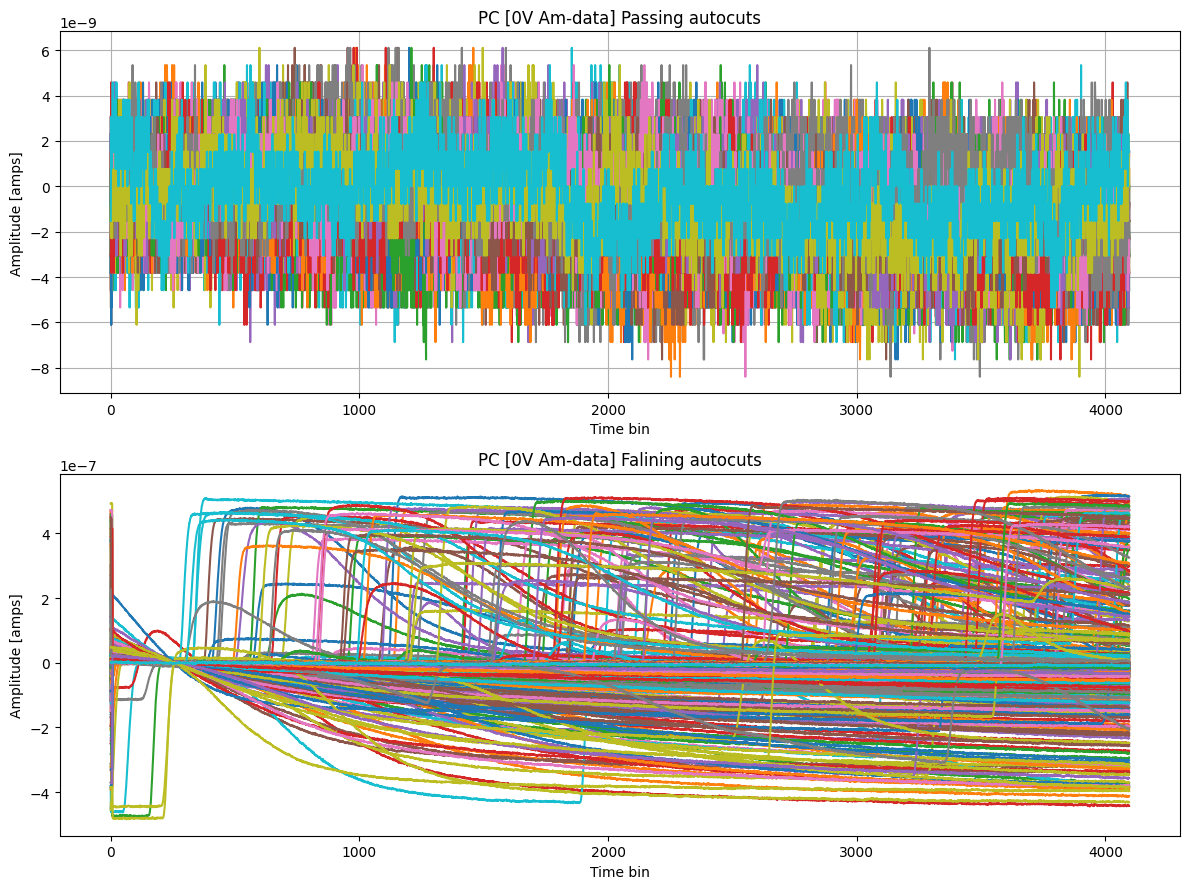

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(12,9))
pp=[(0,0), (0,1)]
eid = 0
#eid = 15000
chan = 'PC'
for trace in tracesAmps[chan][cut[chan]]:
    med_ = np.median(trace[10:500])
    axs[0].plot(trace - med_)

#axs[0].legend(loc='upper right')
#axs[pp[i]].title('PC [0V Am-data]')
axs[0].grid()
#axs[pp[i]].set_ylim([1e-12,1e-10])
axs[0].set_title(chan+' [0V Am-data] Passing autocuts')
axs[0].set_xlabel('Time bin')
axs[0].set_ylabel('Amplitude [amps]')

for trace in tracesAmps[chan][~cut[chan]]:
    med_ = np.median(trace[10:500])
    axs[1].plot(trace - med_)

axs[1].set_title(chan+' [0V Am-data] Falining autocuts')
axs[1].set_xlabel('Time bin')
axs[1].set_ylabel('Amplitude [amps]')

fig.tight_layout()

In [58]:
cut = qp.autocuts(
    traceArray,
    fs = fs
)
print('Cut efficieny is %0.3f'%(np.sum(cut)/len(traceArray)))

Cut efficieny is 0.110


In [60]:
psd_cut = qp.calc_psd(traceArray[cut], fs=fs, folded_over=True)

<>:10: DeprecationWarning: invalid escape sequence \s
<>:10: DeprecationWarning: invalid escape sequence \s
/tmp/ipykernel_1178987/2562002236.py:10: DeprecationWarning: invalid escape sequence \s
  plt.ylabel('Noise PSD [A/$\sqrt{Hz}$]')


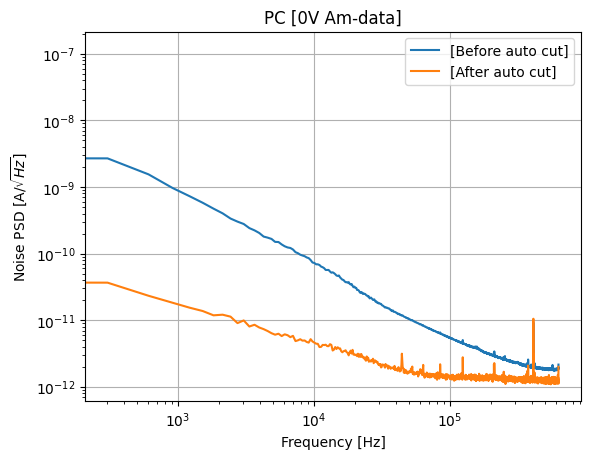

In [63]:
plt.loglog(noise_PSDs[0],np.sqrt(noise_PSDs[1]),label='[Before auto cut]')
plt.loglog(psd_cut[0],np.sqrt(psd_cut[1]),label='[After auto cut]')
#plt.legend(ncol=3, loc='upper left', fontsize=25)
plt.legend(loc='upper right')
plt.title('PC [0V Am-data]')
#plt.title("S101 All Channels, 0V", x=0.4, y=0.7, fontsize = 40)
plt.grid()
#plt.ylim([3e-12,3e-9])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Noise PSD [A/$\sqrt{Hz}$]')
#plt.savefig('Plots/CUTE_R24_series_20April22_21April22_Z5_NoisePSDs_Ba_0V_'+chan+'.png')
#plt.savefig('Plots/CUTE_R24_series_20April22_21April22_Z5_NoisePSDs_Ba_0V_AllChannels.png')
plt.show()